In [1]:
#Load the numpy and scipy libraries
import numpy as np
from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union
import illustris_python as il
import matplotlib.pyplot as plt

In [2]:
@numba.jit(nopython=True, nogil=True)
def tetrahedron_volume(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]],
                                       points[sim[3]] - points[sim[0]])))) / 6

@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = tetrahedron_volume(sim, pts)
        for index in sim:
            rho[index] += vol
    return (3 + 1) * m / rho

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts: float64[:,:], simps: float64[:,:], rho: float64[:],
                      v: float64[:,:]) -> tuple[np.ndarray, np.ndarray]:
    N = len(simps)
    Drho = np.zeros((N, 3), dtype='float64')
    Dv   = np.zeros((N, 3, 3), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2, p3] = pts[s]
        [r0, r1, r2, r3] = rho[s]
        [v0, v1, v2, v3] = v[s]

        Ainv: float64[:,:] = np.linalg.inv(np.stack((p1 - p0, p2 - p0, p3 - p0)))
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0, r3 - r0])
        Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0, v3 - v0))
    return (Drho, Dv)

@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result

#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, velocities, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho, self.Dv = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho, self.velocities)

    #The interpolations
    def density(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])

    def v(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.velocities[pointIndex], self.Dv[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])
    
    def gradV(self, x, y, z):
        return self.Dv[self.delaunay.find_simplex(np.c_[x, y, z])]

    def theta(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        return (self.Dv[simplexIndex][...,0,0] + 
                self.Dv[simplexIndex][...,1,1] + 
                self.Dv[simplexIndex][...,2,2])

    def sigma(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        Dv = self.Dv[simplexIndex]
        theta = Dv[...,0,0] + Dv[...,1,1] + Dv[...,2,2]
        return np.array([[Dv[...,0,0] - theta / 3       , (Dv[...,0,1] + Dv[...,1,0]) / 2, (Dv[...,0,2] + Dv[...,2,0]) / 2],
                        [(Dv[...,1,0] + Dv[...,0,1]) / 2,  Dv[...,1,1] - theta / 3       , (Dv[...,1,2] + Dv[...,2,1]) / 2],
                        [(Dv[...,2,0] + Dv[...,0,2]) / 2, (Dv[...,2,1] + Dv[...,1,2]) / 2,  Dv[...,2,2] - theta / 3       ]]) 
    
    def omega(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        Dv = self.Dv[simplexIndex]
        zeros = np.zeros(len(simplexIndex))
        return (np.array([[zeros, (Dv[...,0,1] - Dv[...,1,0]) / 2, (Dv[...,0,2] - Dv[...,2,0]) / 2],
                          [(Dv[...,1,0] - Dv[...,0,1]) / 2, zeros, (Dv[...,1,2] - Dv[...,2,1]) / 2],
                          [(Dv[...,2,0] - Dv[...,0,2]) / 2, (Dv[...,2,1] - Dv[...,1,2]) / 2, zeros]])) 

In [3]:
L = 75000
n = 256
sigma = 8
gamma = 1

def power(k, gamma):
    return k**gamma

def GRF(L, gamma, sigma):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    k2 = kx**2 + ky**2 + kz**2
    smooth_kernel = np.exp(- sigma ** 2 * k2 / 2)
    grf = np.fft.ifftn(
        np.sqrt(power(k2, gamma)) * 
                smooth_kernel * 
                np.fft.fftn(np.random.normal(0, 1, (L, L, L)))).real
    return grf / np.std(grf)

def gradient(data):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    
    datax = -np.fft.ifftn(kx * np.fft.fftn(data)).imag
    datay = -np.fft.ifftn(ky * np.fft.fftn(data)).imag
    dataz = -np.fft.ifftn(kz * np.fft.fftn(data)).imag
    
    return np.transpose(np.array([datax, datay, dataz]),(1,2,3,0))

def Zeldovich(grf, D):
    velocities = gradient(grf)
    X, Y, Z = np.meshgrid(np.arange(L), np.arange(L), np.arange(L))
    points = np.transpose(np.array([X, Y, Z]), (1,2,3,0)) + D * velocities
    return (points.reshape(L**3, 3), velocities.reshape(L**3, 3))

In [4]:
base_path = "/Users/users/nastase/PROJECT/"

In [5]:
snapnum = 135

In [6]:
dm_data = il.snapshot.loadSubset(base_path,snapnum,'dm',['Coordinates', 'Velocities'])
dm_pos_all = dm_data['Coordinates']
dm_vel_all = dm_data['Velocities']

In [7]:
dm_vel_all = dm_vel_all.astype(np.float64)
dm_pos_all = dm_pos_all.astype(np.float64)

In [9]:
m_all = np.ones(len(dm_vel_all))
m_all = m_all.astype(np.float64)

In [26]:
x_min, x_max = 15_000, 30_000
y_min, y_max = 10_000, 25_000
z_min, z_max = 10_000, 25_000

In [27]:
x_filter = (dm_pos_all[:,0] >= x_min) & (dm_pos_all[:,0] <= x_max)
y_filter = (dm_pos_all[:,1] >= y_min) & (dm_pos_all[:,1] <= y_max) 
z_filter = (dm_pos_all[:,2] >= z_min) & (dm_pos_all[:,2] <= z_max) 

In [28]:
data_filter = x_filter & y_filter & z_filter

In [29]:
dm_pos_subset = dm_pos_all[data_filter].astype(np.float64)
dm_vel_subset = dm_vel_all[data_filter].astype(np.float64)

In [30]:
m_subset = np.ones(len(dm_pos_subset))
m_subset = m_subset.astype(np.float64)

In [40]:
points = dm_pos_subset

In [41]:
normx = points[:,0] - np.min(points[:,0])
normy = points[:,1] - np.min(points[:,1])
normz = points[:,2] - np.min(points[:,2])

points_norm = np.transpose(np.array([normx,normy,normz]))

In [42]:
%%time
dtfe = DTFE(points_norm,dm_vel_subset, m_subset )

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 48.8 s, sys: 721 ms, total: 49.5 s
Wall time: 1min 24s


In [61]:
n=256
L = 75000
wid = 750 ##no idea?

# X,Y,Z = np.meshgrid(np.linspace(-L/2,L/2,n),np.linspace(-L/2,L/2,n),np.linspace(-wid/2,wid/2,n))
X, Y, Z = np.meshgrid(np.linspace(0.01*L, 0.99*L, n),   
                   np.linspace(0.01*L, 0.99*L, n),
                  np.linspace(0.01*L, 0.99*L, n))

In [62]:
d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())

In [63]:
np.max(d)

1199202.5106133865

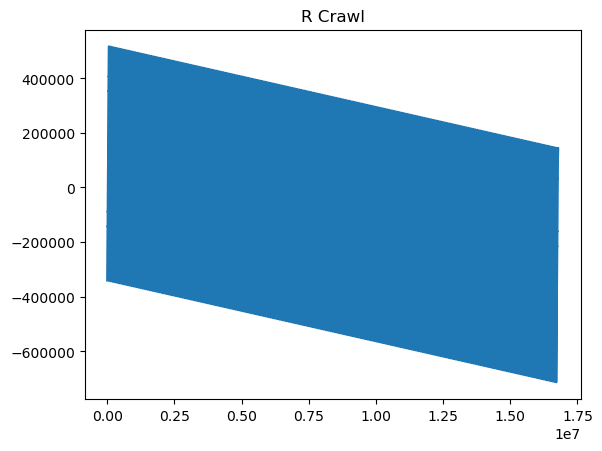

In [47]:
plt.plot(d,label='x')
plt.title('R Crawl')
# plt.yscale('log')
plt.show()


In [57]:
den = d.reshape(n,n,n)

In [58]:
dens = den[1:n-1,1:n-1,1:n-1]

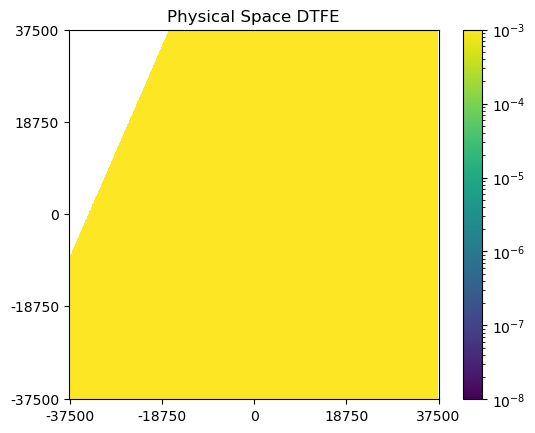

In [59]:
plt.imshow(dens[:,:,int(n/2 -1)],norm="log",origin="lower",vmin =1e-8,vmax = 1e-3 )
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))
plt.title("Physical Space DTFE")
plt.colorbar()
plt.show()
